# Лабораторная работа 1

In [50]:
# !pip install -r requierments.txt

In [51]:

# from sklearn.datasets import fetch_california_housing
# from sklearn.model_selection import train_test_split, KFold
# from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, get_scorer
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.base import clone
# import numpy as np
# import matplotlib.pyplot as plt
# import optuna
# from catboost import CatBoostRegressor
# import time

## Загрузка данных


In [52]:

# data = fetch_california_housing(as_frame=True)
# df = data.frame.copy()
# X = data.data.copy()
# y = data.target.copy()

# print(df.shape)
# df.head()

## Выборка

In [53]:

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

# X_train.shape, X_test.shape, y_train.shape, y_test.shape

## Модели и метрики


In [54]:
# def metrics(y_true, y_pred):
#     mae = mean_absolute_error(y_true, y_pred)
#     rmse = root_mean_squared_error(y_true, y_pred)
#     r2 = r2_score(y_true, y_pred)
#     return {"MAE": mae, "RMSE": rmse, "R2": r2}

In [55]:
# pipeline_lr = Pipeline([
#     ("scaler", StandardScaler()),
#     ("model", LinearRegression())
# ])

# pipeline_lr.fit(X_train, y_train)
# pred_lr = pipeline_lr.predict(X_test)
# metrics_lr = metrics(y_test, pred_lr)

# rf = RandomForestRegressor(
#     n_estimators=200, random_state=42, n_jobs=-1
# )

# rf.fit(X_train, y_train)
# pred_rf = rf.predict(X_test)
# metrics_rf = metrics(y_test, pred_rf)

# print("LinearRegression:", metrics_lr)
# print("RandomForestRegressor:", metrics_rf)

## Графики остатков

In [56]:
# def pred_vs_actual_plot(y_true, y_pred, title):
#     plt.figure()
#     plt.scatter(y_true, y_pred, alpha=0.5)
#     plt.xlabel("Actual")
#     plt.ylabel("Predicted")
#     plt.title(title)
#     plt.show()

# def residuals_vs_pred_plot(y_true, y_pred, title):
#     plt.figure()
#     plt.scatter(y_pred, y_true - y_pred, alpha=0.5)
#     plt.xlabel("Predicted")
#     plt.ylabel("Residuals")
#     plt.title(title)
#     plt.show()

In [57]:
# pred_vs_actual_plot(y_test.values, pred_lr,
#                     title="Predicted vs Actual Plot for LinearRegression")
# residuals_vs_pred_plot(y_test.values, pred_lr,
#                        title="Residuals vs Predicted Plot for LinearRegression")

# pred_vs_actual_plot(y_test.values, pred_rf,
#                     title="Predicted vs Actual Plot for RandomForest")
# residuals_vs_pred_plot(y_test.values, pred_rf,
#                        title="Residuals vs Predicted Plot for RandomForest")

## Подбор гиперпараметров

In [58]:
# def rmse(y_true, y_pred):
#     y_true = np.asarray(y_true, dtype=float)
#     y_pred = np.asarray(y_pred, dtype=float)
#     return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

In [59]:
# def objective_rf(trial):
#     n_estimators = trial.suggest_int("n_estimators", 100, 600, step=50)
#     max_depth = trial.suggest_int("max_depth", 3, 30)
#     min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
#     min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

#     base_model = RandomForestRegressor(
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         min_samples_split=min_samples_split,
#         min_samples_leaf=min_samples_leaf,
#         random_state=42,
#         n_jobs=-1
#     )

#     crossvalidation = KFold(n_splits=3, shuffle=True, random_state=42)
#     fold_scores = []

#     indexes = np.arange(len(X_train))

#     for fold_id, (train, valid) in enumerate(crossvalidation.split(indexes)):
#         model = clone(base_model)

#         X_tr = X_train.iloc[train]
#         y_tr = y_train.iloc[train]
#         X_vl = X_train.iloc[valid]
#         y_vl = y_train.iloc[valid]

#         try:
#             model.fit(X_tr, y_tr)
#             y_pr = model.predict(X_vl)
#             score_rmse = rmse(y_vl, y_pr)
#         except Exception as e:
#             print(f"trial={trial.number} | fold {fold_id} error: {e}")
#             score_rmse = float("inf")

#         fold_scores.append(score_rmse)

#         print(f"trial={trial.number} | fold {fold_id}: RMSE={score_rmse}")

#     mean_rmse = float(np.mean(fold_scores)) if len(
#         fold_scores) else float("inf")
#     print(f"trial={trial.number} | mean RMSE={mean_rmse}")
#     return -mean_rmse

In [60]:
# study = optuna.create_study(direction="maximize")
# study.optimize(objective_rf, n_trials=30)

# print("Best params:", study.best_params)
# print("Best (neg-RMSE):", study.best_value)

## Фабрика

In [61]:
# def gen_objective(estimator_class, grid, X_train, y_train,
#                   *, cv=3, scorer="neg_root_mean_squared_error",
#                   fit_params=None, random_state=42, n_jobs=-1, verbose=True):
#     fit_params = {} if fit_params is None else dict(fit_params)

#     if not isinstance(grid, dict) or not grid:
#         raise ValueError(
#             "grid must be not empty dict ({param: (type, ...)})")

#     def suggest_param(trial, name, spec):
#         if not isinstance(spec, (tuple, list)) or not spec:
#             raise ValueError(f"Error spec {name}: {spec}")
#         ptype = spec[0]
#         if ptype == "int":
#             low, high = spec[1], spec[2]
#             step = spec[3] if len(spec) > 3 else 1
#             return trial.suggest_int(name, int(low), int(high), step=int(step))
#         elif ptype == "float":
#             low, high = float(spec[1]), float(spec[2])
#             log = bool(spec[3]) if len(spec) > 3 else False
#             return trial.suggest_float(name, low, high, log=log)
#         elif ptype == "categorical":
#             choices = list(spec[1])
#             return trial.suggest_categorical(name, choices)
#         else:
#             raise ValueError(
#                 f"Error space type {ptype} for {name}")

#     if isinstance(scorer, str):
#         try:
#             scorer_obj = get_scorer(scorer)
#         except Exception:
#             if verbose:
#                 print(
#                     f"Error scorer={scorer} | used=neg_root_mean_squared_error")
#             scorer_obj = get_scorer("neg_root_mean_squared_error")
#     else:
#         scorer_obj = scorer

#     idx = np.arange(len(X_train))

#     def objective(trial):
#         t0 = time.time()

#         params = {name: suggest_param(trial, name, spec)
#                   for name, spec in grid.items()}

#         try:
#             probe = estimator_class()
#             base_params = getattr(probe, "get_params", lambda: {})()
#         except Exception:
#             base_params = {}

#         model_kwargs = {}
#         if "random_state" in base_params:
#             model_kwargs["random_state"] = random_state
#         if "n_jobs" in base_params:
#             model_kwargs["n_jobs"] = n_jobs

#         model = estimator_class(**model_kwargs, **params)

#         kf = KFold(n_splits=cv, shuffle=True, random_state=42)
#         fold_scores = []

#         for fold_id, (tr_idx, vl_idx) in enumerate(kf.split(idx), start=1):
#             m = clone(model)
#             X_tr = X_train.iloc[tr_idx]
#             y_tr = y_train.iloc[tr_idx]
#             X_vl = X_train.iloc[vl_idx]
#             y_vl = y_train.iloc[vl_idx]

#             try:
#                 m.fit(X_tr, y_tr, **fit_params)
#                 s = scorer_obj(m, X_vl, y_vl)
#                 s = float(s)
#                 if not np.isfinite(s):
#                     if verbose:
#                         print(
#                             f"trial={trial.number} | fold {fold_id}: score is not finite, set to -1e12")
#                     s = -1e12
#             except Exception as e:
#                 if verbose:
#                     print(
#                         f"trial={trial.number} | fold {fold_id} error: {e}")
#                 s = -1e12

#             fold_scores.append(s)

#             if verbose:
#                 print(f"trial {trial.number} | fold {fold_id} score={s}")

#         mean_score = float(np.mean(fold_scores)) if fold_scores else -1e12
#         if not np.isfinite(mean_score):
#             mean_score = -1e12

#         if verbose:
#             dt = time.time() - t0
#             print(
#                 f"trial={trial.number} | mean_score={mean_score} | time={dt} | params={params}")

#         return mean_score

#     return objective

In [62]:
# from catboost import CatBoostRegressor
# import optuna

# catboost_grid = {
#     "depth": ("int", 4, 10),
#     "learning_rate": ("float", 1e-3, 0.3, True),
#     "l2_leaf_reg": ("float", 1e-2, 10.0, True),
#     "iterations": ("int", 200, 1500, 100),
# }

# objective_cb = gen_objective(
#     CatBoostRegressor,
#     catboost_grid,
#     X_train,
#     y_train,
#     cv=3,
#     scorer="neg_root_mean_squared_error",
#     fit_params={"verbose": False},
#     random_state=42,
#     n_jobs=-1,
#     verbose=True
# )

# study_cb = optuna.create_study(direction="maximize")
# study_cb.optimize(objective_cb, n_trials=30)

# print("Best CatBoost params:", study_cb.best_params)
# print("Best CV score (neg-RMSE):", study_cb.best_value)

# best_cb = CatBoostRegressor(
#     **study_cb.best_params,
#     random_state=42,
#     verbose=False
# )
# best_cb.fit(X_train, y_train)

# pred_best_cb = best_cb.predict(X_test)

# metrics(y_test, pred_best_cb)

# pred_vs_actual_plot(
#     y_test.values, pred_best_cb,
#     title="Predicted vs Actual (Best CatBoost)"
# )
# residuals_vs_pred_plot(
#     y_test.values, pred_best_cb,
#     title="Residuals vs Predicted (Best CatBoost)"
# )

# Лабораторная работа 2

Базовая версия Python: 3.14.0

In [63]:
# pip install -r requierments.txt

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

SEED = 42
np.random.seed(SEED)

In [2]:
df = pd.read_csv("portal_data.csv", encoding="utf-8", sep="|")
df.head()

,Вектор Мощи,Скорость перехода через портал,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Температура вдоха Истока,Температура выдоха Истока,Приток давления Выдоха Истока,Давление вдоха Истока,Давление выдоха Истока,Древний Ветер,Печать Чародея,Эмульсия Истока,Дыхание Истока,Гармония Бессмертия,Тип Вектора Мощи,Номер пометки
0,1.138,1.54332,289.964,141.318158,6677.380,7.584,7.584,464.006,736,-,1.096,Не определено,5.947,-,7.137,0.082,0.95,0.975,Слабый,0
1,2.088,-,6960.180,144.111767,6828.469,28.204,28.204,635.401,736,581.658,1.331,1.394603,7.282,1.019,10.655,0.287,0.95,0.975,Слабый,1
2,3.144,4.6299600000000005,8379.229,145.220853,7111.811,60.358,60.358,606.002,736,-,1.389,Не определено,7.574,-,13.086,0.259,0.95,0.975,Ниже среднего,2
3,4.161,6.17328,14724.395,162.050156,7792.630,113.774,113.774,661.471,736,-,1.658,Не определено,9.007,-,18.109,0.358,0.95,0.975,Ниже среднего,3
4,5.140,7.7166,21636.432,201.513586,8494.777,175.306,175.306,731.494,736,645.642,2.078,Не определено,11.197,1.026,26.373,0.522,0.95,0.975,Выше среднего,4


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11934 entries, 0 to 11933
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Вектор Мощи                     11934 non-null  float64
 1   Скорость перехода через портал  11934 non-null  object 
 2   Приток Силы Потока              11934 non-null  float64
 3   Ритм магического ядра           11934 non-null  float64
 4   Поток Энергий                   11934 non-null  float64
 5   Сила Левого Потока              11934 non-null  float64
 6   Сила Правого Потока             11934 non-null  float64
 7   Пламя Стихий                    11934 non-null  float64
 8   Температура вдоха Истока        11934 non-null  int64  
 9   Температура выдоха Истока       11934 non-null  object 
 10  Приток давления Выдоха Истока   11934 non-null  float64
 11  Давление вдоха Истока           11934 non-null  object 
 12  Давление выдоха Истока          

`Скорость перехода через портал`, `Температура выдоха Истока`, `Давление вдоха Истока`, `Древний Ветер` сейчас имеют тип **object**, их нужно преобразовать в численный тип данных.

In [4]:
cols = [
    "Скорость перехода через портал",
    "Температура выдоха Истока",
    "Давление вдоха Истока",
    "Древний Ветер",
]

df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")

| **№** | **Признак** | **Описание** | **Тип данных признака** |
| ------ | ---- | ---- | ---- |
| **1** | Вектор Мощи | Позиция магического механизма, управляющего режимом портала | Вещественный |
| **2** | Скорость перехода через портал | Скорость перемещения объекта при прохождении портала | Вещественный |
| **3** | Приток Силы Потока | Значение магического потока, питающего портал | Вещественный |
| **4** | Ритм магического ядра | Частота работы магического ядра портала | Вещественный |
| **5** | Поток Энергий | Интенсивность энергообмена в магическом контуре | Вещественный |
| **6** | Сила Левого Потока | Интенсивность левого энергетического канала | Вещественный |
| **7** | Сила Правого Потока | Интенсивность правого энергетического канала | Вещественный |
| **8** | Пламя Стихий | Температура магической энергии в ядре портала | Вещественный |
| **9** | Температура вдоха Истока | Температура воздуха на входе магического источника | Вещественный |
| **10** | Температура выдоха Истока | Температура воздуха на выходе магического источника | Вещественный |
| **11** | Приток давления Выдоха Истока | Поток давления, создаваемый в процессе "выдоха" Истока | Вещественный |
| **12** | Давление выдоха Истока | Давление на выходе магического источника | Вещественный |
| **13** | Давление вдоха Истока | Давление на входе магического источника | Вещественный |
| **14** | Древний Ветер | Дополнительный параметр магического окружения | Вещественный |
| **15** | Печать Чародея | Управляющий параметр контроля портала | Вещественный |
| **16** | Эмульсия Истока | Количество магического горючего/эмульсии | Вещественный |
| **17** | Дыхание Истока | Коэффициент угасания / дыхания энергии | Вещественный |
| **18** | Гармония Бессмертия | Показатель состояния портала, целевая переменная | Вещественный |
| **19** | Тип Вектора Мощи | Категориальный тип режима, связанный с Вектором Мощи | Категориальный |
| **20** | Номер пометки | Уникальный идентификатор записи | Целочисленный |


Целевым значением выступает признак:
"Гармония Бессмертия";

In [5]:
df.describe()

,Вектор Мощи,Скорость перехода через портал,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Температура вдоха Истока,Температура выдоха Истока,Приток давления Выдоха Истока,Давление вдоха Истока,Давление выдоха Истока,Древний Ветер,Печать Чародея,Эмульсия Истока,Дыхание Истока,Гармония Бессмертия,Номер пометки
count,11934.000000,10731.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.0,2387.000000,11934.000000,2439.000000,11934.000000,2387.000000,11934.000000,11934.000000,11934.00000,11934.0000,11934.000000
mean,5.166667,7.721490,27247.498685,223.711688,8200.947312,227.335768,227.335768,735.495446,736.0,646.092576,2.352963,1.394603,12.297123,1.029413,33.641261,0.662440,0.97500,0.9875,5966.500000
std,2.626388,3.993642,22148.613155,81.061874,1091.315507,200.495889,200.495889,173.680552,0.0,71.394305,1.084770,0.000000,5.337448,0.010217,25.841363,0.507132,0.01472,0.0075,3445.193391
min,1.138000,1.543320,253.547000,136.939406,6589.002000,5.304000,5.304000,442.364000,736.0,542.994000,1.093000,1.394603,5.828000,1.019000,0.000000,0.068000,0.95000,0.9750,0.000000
25%,3.144000,4.629960,8375.883750,145.220958,7058.324000,60.317000,60.317000,589.872750,736.0,579.362000,1.389000,1.394603,7.447250,1.020000,13.677500,0.246000,0.96200,0.9810,2983.250000
50%,5.140000,7.716600,21630.659000,201.514947,8482.081500,175.268000,175.268000,706.038000,736.0,636.963000,2.083000,1.394603,11.092000,1.026000,25.276500,0.496000,0.97500,0.9875,5966.500000
75%,7.148000,10.803240,39001.426750,280.447777,9132.606000,332.364750,332.364750,834.066250,736.0,692.152000,2.981000,1.394603,15.658000,1.036000,44.552500,0.882000,0.98800,0.9940,8949.750000
max,9.300000,13.889880,72784.872000,372.879926,9797.103000,645.249000,645.249000,1115.797000,736.0,788.433000,4.560000,1.394603,23.140000,1.052000,92.556000,1.832000,1.00000,1.0000,11933.000000


`Температура вдоха Истока` имеет одно и то же значение во всех строках признака, поэтому имеет смысл удалить данный признак.

In [6]:
df.head()

,Вектор Мощи,Скорость перехода через портал,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Температура вдоха Истока,Температура выдоха Истока,Приток давления Выдоха Истока,Давление вдоха Истока,Давление выдоха Истока,Древний Ветер,Печать Чародея,Эмульсия Истока,Дыхание Истока,Гармония Бессмертия,Тип Вектора Мощи,Номер пометки
0,1.138,1.54332,289.964,141.318158,6677.380,7.584,7.584,464.006,736,NaN,1.096,NaN,5.947,NaN,7.137,0.082,0.95,0.975,Слабый,0
1,2.088,NaN,6960.180,144.111767,6828.469,28.204,28.204,635.401,736,581.658,1.331,1.394603,7.282,1.019,10.655,0.287,0.95,0.975,Слабый,1
2,3.144,4.62996,8379.229,145.220853,7111.811,60.358,60.358,606.002,736,NaN,1.389,NaN,7.574,NaN,13.086,0.259,0.95,0.975,Ниже среднего,2
3,4.161,6.17328,14724.395,162.050156,7792.630,113.774,113.774,661.471,736,NaN,1.658,NaN,9.007,NaN,18.109,0.358,0.95,0.975,Ниже среднего,3
4,5.140,7.71660,21636.432,201.513586,8494.777,175.306,175.306,731.494,736,645.642,2.078,NaN,11.197,1.026,26.373,0.522,0.95,0.975,Выше среднего,4


In [7]:
df = df.replace({"-": np.nan, "Не определено": np.nan})
df.isna().sum()

Вектор Мощи                          0
Скорость перехода через портал    1203
Приток Силы Потока                   0
Ритм магического ядра                0
Поток Энергий                        0
Сила Левого Потока                   0
Сила Правого Потока                  0
Пламя Стихий                         0
Температура вдоха Истока             0
Температура выдоха Истока         9547
Приток давления Выдоха Истока        0
Давление вдоха Истока             9495
Давление выдоха Истока               0
Древний Ветер                     9547
Печать Чародея                       0
Эмульсия Истока                      0
Дыхание Истока                       0
Гармония Бессмертия                  0
Тип Вектора Мощи                     0
Номер пометки                        0
dtype: int64

В признаках: `Температура выдоха Истока`, `Давление вдоха Истока`, `Древний Ветер` - почти полностью отсутствуют данные, поэтому их лучше полностью удалить.

`Номер пометки` не имеет смысла, так как является простым номером строки.

`Тип Вектора Мощи` - категориальный признак, очень схожий со значениями числового признака `Вектор Мощи`, далее необходимо будет проверить работу модели с данным признаком и без:
* с признаком `Тип Вектора Мощи`;
* без признака `Тип Вектора Мощи`.

In [8]:
drop_cols = [
    "Температура вдоха Истока",
    "Температура выдоха Истока",
    "Давление вдоха Истока",
    "Древний Ветер",
    "Номер пометки",
]

df = df.drop(columns=drop_cols, errors="ignore")

In [9]:
X = df.drop(columns=["Гармония Бессмертия"])
y = df["Гармония Бессмертия"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

len(X_train), len(X_test)

(9547, 2387)

# Лабораторная работа 3

In [72]:
X_train.isna().sum()

Вектор Мощи                         0
Скорость перехода через портал    961
Приток Силы Потока                  0
Ритм магического ядра               0
Поток Энергий                       0
Сила Левого Потока                  0
Сила Правого Потока                 0
Пламя Стихий                        0
Приток давления Выдоха Истока       0
Давление выдоха Истока              0
Печать Чародея                      0
Эмульсия Истока                     0
Дыхание Истока                      0
dtype: int64

In [ ]:
missing = X_train["Скорость перехода через портал"].isna().sum()
total = len(X_train)

missing / total

(np.int64(961), np.float64(0.10065989316015503))

Процент пропусков в признаке `Скорость перехода через портал` имеет процентр пропусков ~10%, поэтому для заполенния попробуем использовать два способа заполнения:
* статистический подход,
* машинный подход;

In [76]:
X_train["Скорость перехода через портал"].describe()

count    8586.000000
mean        7.715162
std         4.000770
min         1.543320
25%         4.629960
50%         7.716600
75%        10.803240
max        13.889880
Name: Скорость перехода через портал, dtype: float64

In [77]:
X_train.corr(numeric_only=True)[
    "Скорость перехода через портал"].sort_values(ascending=False)

Скорость перехода через портал    1.000000
Вектор Мощи                       0.999915
Поток Энергий                     0.986860
Давление выдоха Истока            0.967075
Приток давления Выдоха Истока     0.960716
Ритм магического ядра             0.960551
Пламя Стихий                      0.958854
Приток Силы Потока                0.958338
Сила Правого Потока               0.956508
Сила Левого Потока                0.956508
Эмульсия Истока                   0.927933
Печать Чародея                    0.909325
Дыхание Истока                   -0.002598
Name: Скорость перехода через портал, dtype: float64

In [78]:
X_train["Скорость перехода через портал"].value_counts().sort_index()

Скорость перехода через портал
1.54332     961
3.08664     980
4.62996     924
6.17328     959
7.71660     950
9.25992     932
10.80324    956
12.34656    957
13.88988    967
Name: count, dtype: int64

In [79]:
X_train_KNN = X_train.copy()
X_train_RF = X_train.copy()

In [80]:
speed_levels = X_train["Скорость перехода через портал"].dropna().unique()
speed_levels = np.sort(speed_levels)
speed_levels

array([ 1.54332,  3.08664,  4.62996,  6.17328,  7.7166 ,  9.25992,
       10.80324, 12.34656, 13.88988])

In [81]:
from sklearn.ensemble import RandomForestRegressor

mask_missing = X_train["Скорость перехода через портал"].isna()
mask_not_missing = ~mask_missing

feature_cols = X_train.columns.drop("Скорость перехода через портал")

X_train_mis = X_train.loc[mask_not_missing, feature_cols]
y_train_mis = X_train.loc[mask_not_missing, "Скорость перехода через портал"]

model = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)
model.fit(X_train_mis, y_train_mis)

,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [82]:
X_missing = X_train.loc[mask_missing, feature_cols]
predicted = model.predict(X_missing)

In [83]:
def nearest_level(x, levels):
    return levels[np.argmin(np.abs(levels - x))]


X_train_KNN.loc[mask_missing, "Скорость перехода через портал"] = [
    nearest_level(p, speed_levels) for p in predicted
]

In [84]:
from sklearn.impute import KNNImputer

missing_mask = X_train_RF["Скорость перехода через портал"].isna()

num_cols = X_train_RF.select_dtypes(include=["float64", "int64"]).columns

imputer = KNNImputer(n_neighbors=5)
X_train_RF[num_cols] = imputer.fit_transform(X_train_RF[num_cols])

In [85]:
def nearest_level(x, levels):
    return levels[np.argmin(np.abs(levels - x))]


X_train_RF.loc[missing_mask, "Скорость перехода через портал"] = X_train_RF.loc[missing_mask, "Скорость перехода через портал"].apply(
    lambda x: nearest_level(x, speed_levels)
)

In [86]:
X_train_KNN["Скорость перехода через портал"].value_counts().sort_index()

Скорость перехода через портал
1.54332     1067
3.08664     1080
4.62996     1041
6.17328     1080
7.71660     1054
9.25992     1043
10.80324    1071
12.34656    1048
13.88988    1063
Name: count, dtype: int64

In [87]:
X_train_RF["Скорость перехода через портал"].value_counts().sort_index()

Скорость перехода через портал
1.54332     1067
3.08664     1080
4.62996     1041
6.17328     1080
7.71660     1054
9.25992     1043
10.80324    1071
12.34656    1048
13.88988    1063
Name: count, dtype: int64

In [88]:
X_train = X_train_KNN.copy()

In [89]:
X_train.isna().sum()

Вектор Мощи                       0
Скорость перехода через портал    0
Приток Силы Потока                0
Ритм магического ядра             0
Поток Энергий                     0
Сила Левого Потока                0
Сила Правого Потока               0
Пламя Стихий                      0
Приток давления Выдоха Истока     0
Давление выдоха Истока            0
Печать Чародея                    0
Эмульсия Истока                   0
Дыхание Истока                    0
dtype: int64

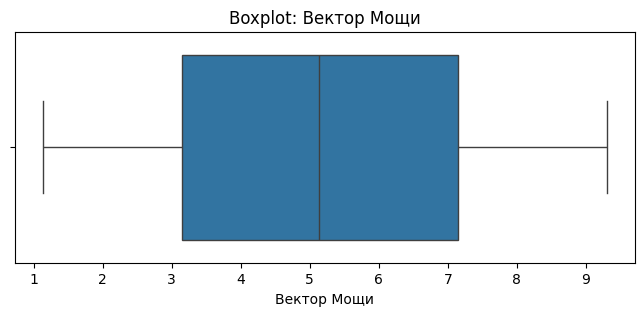

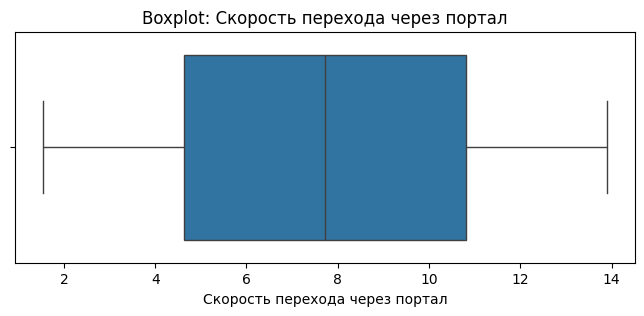

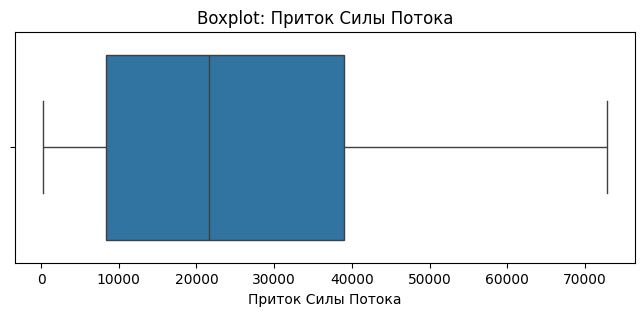

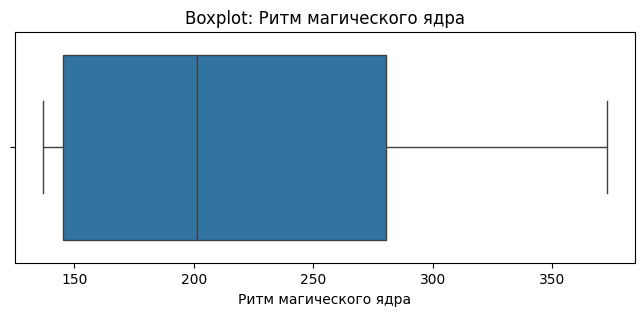

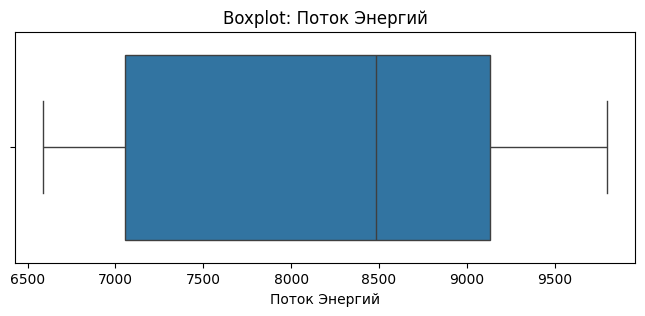

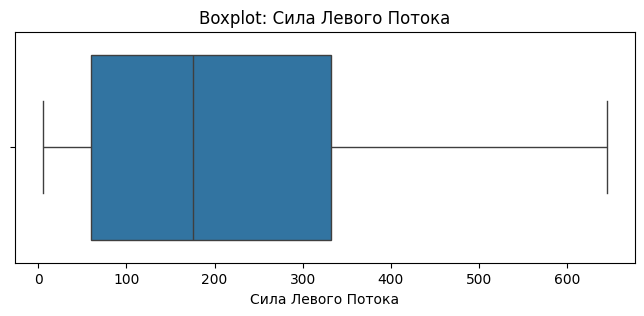

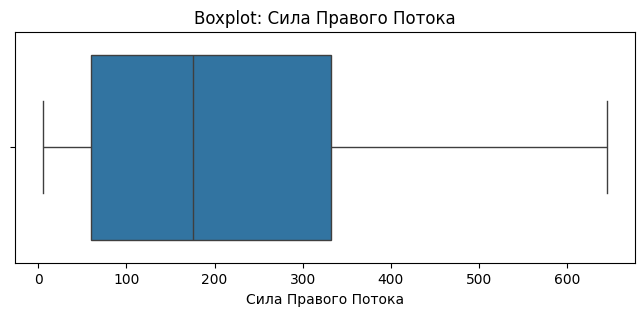

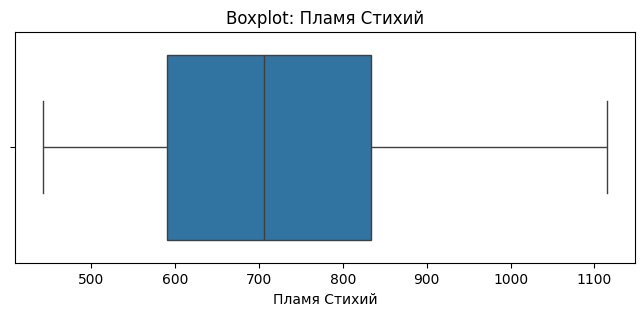

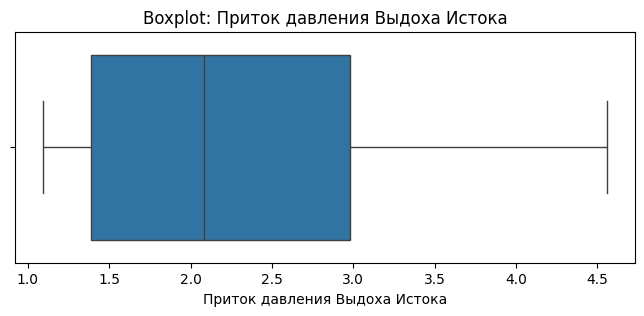

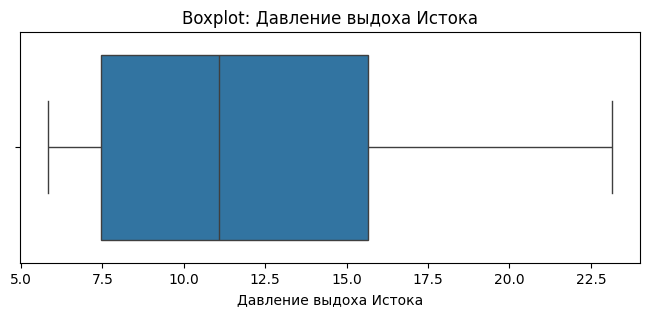

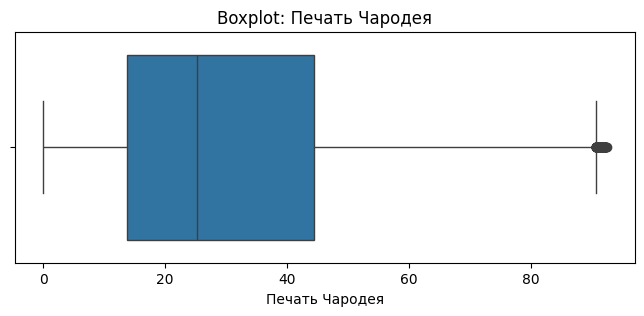

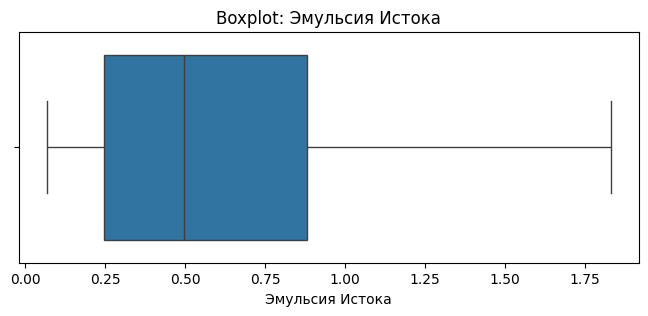

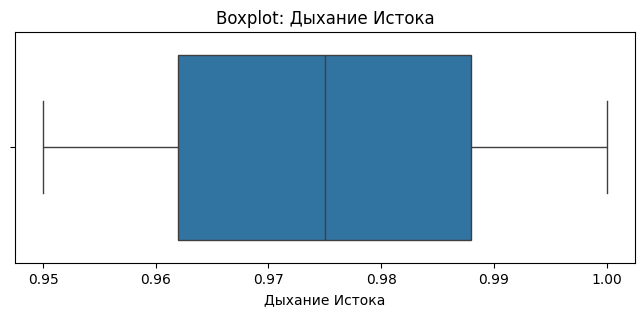

In [90]:
for col in X_train.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(8, 3))
    sns.boxplot(x=X_train[col])
    plt.title(f"Boxplot: {col}")
    plt.show()

In [91]:
X_train.describe()

,Вектор Мощи,Скорость перехода через портал,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Приток давления Выдоха Истока,Давление выдоха Истока,Печать Чародея,Эмульсия Истока,Дыхание Истока
count,9547.000000,9547.000000,9547.000000,9547.000000,9547.000000,9547.000000,9547.000000,9547.000000,9547.000000,9547.000000,9547.00000,9547.000000,9547.000000
mean,5.157165,7.702213,27189.342424,223.477312,8196.968701,226.834525,226.834525,734.909839,2.349972,12.281358,33.59335,0.661169,0.975062
std,2.629660,3.989909,22168.866459,81.105784,1092.544520,200.675530,200.675530,173.868978,1.085541,5.340778,25.85155,0.507523,0.014734
min,1.138000,1.543320,253.547000,136.939406,6589.002000,5.304000,5.304000,442.364000,1.093000,5.828000,0.00000,0.068000,0.950000
25%,3.144000,4.629960,8375.697000,145.220958,7055.564500,60.316000,60.316000,589.721500,1.389000,7.444000,13.75650,0.246000,0.962000
50%,5.140000,7.716600,21630.323000,201.514947,8481.228000,175.266000,175.266000,705.465000,2.082000,11.084000,25.24200,0.496000,0.975000
75%,7.148000,10.803240,39001.468000,280.447672,9132.444000,332.363000,332.363000,833.800500,2.981000,15.656000,44.52950,0.882000,0.988000
max,9.300000,13.889880,72784.872000,372.879926,9797.103000,645.249000,645.249000,1114.609000,4.558000,23.133000,92.47600,1.831000,1.000000


In [92]:
s = X_train["Печать Чародея"].dropna()
Q1 = s.quantile(0.25)
Q3 = s.quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

outliers_mask = (X_train["Печать Чародея"] > upper_bound)

X_train[outliers_mask].describe()

,Вектор Мощи,Скорость перехода через портал,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Приток давления Выдоха Истока,Давление выдоха Истока,Печать Чародея,Эмульсия Истока,Дыхание Истока
count,1.860000e+02,1.860000e+02,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000
mean,9.300000e+00,1.388988e+01,72766.853027,372.844978,9774.451237,644.914188,644.914188,1101.545710,4.499500,22.692538,91.314382,1.807602,0.957505
std,1.781151e-15,1.781151e-15,4.072070,0.001576,9.093886,0.130516,0.130516,5.784705,0.011021,0.142560,0.451091,0.008937,0.005823
min,9.300000e+00,1.388988e+01,72759.569000,372.841179,9751.200000,644.706000,644.706000,1089.292000,4.477000,22.350000,90.690000,1.795000,0.950000
25%,9.300000e+00,1.388988e+01,72763.631000,372.843797,9768.078000,644.792250,644.792250,1097.325750,4.492000,22.592250,90.927000,1.800000,0.952250
50%,9.300000e+00,1.388988e+01,72766.398500,372.845002,9775.760500,644.892500,644.892500,1101.336500,4.499000,22.711000,91.233000,1.806000,0.956000
75%,9.300000e+00,1.388988e+01,72770.036500,372.846206,9781.527500,645.052250,645.052250,1105.625250,4.508000,22.806500,91.627000,1.814000,0.962000
max,9.300000e+00,1.388988e+01,72776.613000,372.848405,9791.421000,645.135000,645.135000,1114.609000,4.526000,22.961000,92.476000,1.831000,0.973000


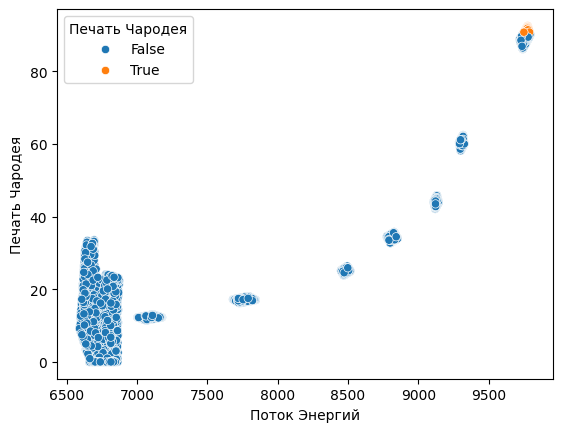

In [93]:
sns.scatterplot(x=X_train["Поток Энергий"],
                y=X_train["Печать Чародея"], hue=outliers_mask)
plt.show()

In [94]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    contamination=0.02,
    random_state=42
)

iso.fit(X_train)

iso_labels = iso.predict(X_train)

X_train["is_iso_anomaly"] = (iso_labels == -1)


In [95]:
X_train["is_iso_anomaly"].value_counts()


is_iso_anomaly
False    9356
True      191
Name: count, dtype: int64

In [96]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.02
)

lof_labels = lof.fit_predict(X_train)
X_train["is_lof_anomaly"] = (lof_labels == -1)


In [97]:
X_train["is_lof_anomaly"].value_counts()

is_lof_anomaly
False    9356
True      191
Name: count, dtype: int64

<Axes: xlabel='Поток Энергий', ylabel='Печать Чародея'>

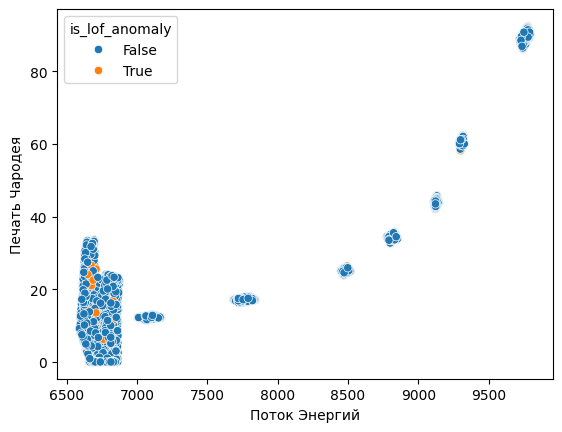

In [98]:
sns.scatterplot(
    x=X_train["Поток Энергий"],
    y=X_train["Печать Чародея"],
    hue=X_train["is_lof_anomaly"]
)